# Predicting movie sales from Metacritic data

## 0. Business problem

The movie industry faces high financial-performance risks because of increasingly high movie-making and marketing costs and a high degree of uncertainty about audience reactions (Escoffier et al., 2015).
While Metacritic provides rich information about movies such as the critic scores, user scores, review texts and metadata, it is 
unclear how well these features can predict the monetary success. That's why this project uses historical data from Metacritic and movie sales information information to build several machine learning models that forecast whether a movie will result in low, medium or high sales. Furthermore, this project will focus on explaining which features drive these predictions. 
The final goal is to provide the movie publisher with valuable information on where to spend the marketing budget.

**Business Question** How can we predict box office perfomance of the movie to accuratly allocate marketing budget?

**Source**:
Escoffier, N., & McKelvey, B. (2015). The Wisdom of Crowds in the Movie Industry: Towards New Solutions to Reduce Uncertainties. International Journal of Arts Management, 17(2), 52–63. http://www.jstor.org/stable/24587073

### 0.1 Main research question & subquestions
**Main research question**:
How accurately can we predict a movie's box-office sales using Metacritic ratings, metadata, review texts, with particular focus on identifying the most influential predictive factors?

**Subquestions**
1. How are critic scores, user scores, genres, platforms, and release years related to the sales tiers of movies?
2. How well can different machine learning models predict the sales tier of a movie, based on structured features?
3. To what extent does adding transformers of review titles and/or movie summaries improve prediction performance compared to models using only structured features? 
4. Which features are most influential in predicting high versus low sales according to SHAP?
5. Can we identify review topics and/or movie clusters (e.g., using BERTopic and clustering methods) that are particularly associated with high or low sales tiers, and do these insights reveal distinct market segments?

The movie sales prediction dataset is contained in the dataset folder in the repository. We will read the data and clean it to make it ready for analysis.

The following information is provided on the dataset variables selected to address the research questions:

This research employs a continuous numerical variable, **Worldwide Box Office**, as the response variable. This represents the total revenue generated globally (in USD).

This study reviewed the literature and used the following 10 variables as explanatory variables:

- **X1**: Metascore
  - A weighted average of critic reviews (Scale: 0 - 100).
- **X2**: Userscore
  - Average score provided by general users (Scale: 0 - 10).
- **X3**: Production Budget
  - The estimated financial cost to produce the film (USD).
- **X4**: Genre
  - Categorical variable indicating the primary classification of the movie (e.g., Action, Comedy, Drama).
  - Movies with multiple genres are processed using One-Hot Encoding.
- **X5**: Release Date
  - Used to extract the specific month and year of release to account for seasonal market trends and inflation adjustments.
- **X6**: Runtime
  - The duration of the movie in minutes.
- **X7**: Theatre Count
  - The number of theatres showing the movie during its opening weekend, serving as a proxy for distribution width.
- **X8**: MPAA Rating
  - Categorical certification defining the target audience scope:
    - G = General Audiences
    - PG = Parental Guidance Suggested
    - PG-13 = Parents Strongly Cautioned
    - R = Restricted
    - NC-17 = Adults Only
- **X9**: Movie Summary
  - The textual plot summary of the film.
  - Used to generate semantic embeddings via Transformers to capture narrative elements.
- **X10**: Review Text
  - The raw text body of expert and user reviews.
  - Used for BERTopic modeling to identify dominant discourse topics associated with sales performance.

## 1. EDA (exploratory data analysis)

In [50]:
import numpy as np
import pandas as pd
import os
import scipy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)
import re, hashlib

### 1.1 Basic structure of the datasets

In [51]:
# define file paths relative to the notebook
data_folder = "datasets"

sales_path = os.path.join(data_folder, "sales.xlsx")
userreviews_path = os.path.join(data_folder, "UserReviews.xlsx")
expertreviews_path = os.path.join(data_folder, "ExpertReviews.xlsx")
meta_path = os.path.join(data_folder, "metaClean43Brightspace.xlsx")

In [52]:
# Load the four Excel files
UserReviews_raw = pd.read_excel(userreviews_path)
ExpertReviews_raw = pd.read_excel(expertreviews_path)
sales_raw       = pd.read_excel(sales_path)
meta_raw        = pd.read_excel(meta_path)

In [53]:
print("There are {} rows and {} columns in the user review dataset".format(UserReviews_raw.shape[0], UserReviews_raw.shape[1]))
print("There are {} rows and {} columns in the expert review dataset".format(ExpertReviews_raw.shape[0], ExpertReviews_raw.shape[1]))
print("There are {} rows and {} columns in the sales dataset".format(sales_raw.shape[0], sales_raw.shape[1]))
print("There are {} rows and {} columns in the meta dataset".format(meta_raw.shape[0], meta_raw.shape[1]))

There are 319662 rows and 7 columns in the user review dataset
There are 238973 rows and 5 columns in the expert review dataset
There are 30612 rows and 16 columns in the sales dataset
There are 11364 rows and 13 columns in the meta dataset


In [54]:
print("UserReview ")
UserReviews_raw.head()
UserReviews_raw.tail()
print("Expert Review")
ExpertReviews_raw.head()
ExpertReviews_raw.tail()
print("Meta data")
meta_raw.head()
meta_raw.tail()
print("Sales data")
sales_raw.head()
sales_raw.tail()


UserReview 


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot
0,https://www.metacritic.com/movie/bronson,8,'Longbottom94',"'Apr 25, 2013'",'Many have dismissed this film for not explor...,2,2
1,https://www.metacritic.com/movie/bronson,9,'MartinB',"'Oct 13, 2009'",'Anyone who doesn t like this movie simply ju...,0,1
2,https://www.metacritic.com/movie/bronson,10,'Jaakko',"'Jul 19, 2012'",'Not sure what to think at this film at first...,1,1
3,https://www.metacritic.com/movie/bronson,6,'CapoR',"'Oct 13, 2009'",'Nicely portrayed but it lacks the elements t...,0,1
4,https://www.metacritic.com/movie/bronson,8,'OrwellB.',"'Oct 10, 2009'",'Bronson is more than entertainment. It is ar...,0,0


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot
319657,https://www.metacritic.com/movie/spirited-away,10,'Zenflar',"'Sep 6, 2021'",'A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+A+...,0,0
319658,https://www.metacritic.com/movie/spirited-away,10,'juiliopaublito',"'Nov 25, 2021'",'in my opinion spirited away is one of the be...,0,0
319659,https://www.metacritic.com/movie/spirited-away,10,'PorridgeBoy3000',"'Dec 31, 2021'",'Usually I don t like watching movies that mu...,0,0
319660,https://www.metacritic.com/movie/spirited-away,10,'jamesfhall',"'Jan 20, 2022'",'Studio Ghibli s gripping masterpiece Spirite...,0,0
319661,https://www.metacritic.com/movie/spirited-away,10,'Motoritz',"'Feb 7, 2022'",'Words cannot describe how amazing this movie...,0,0


Expert Review


,url,idvscore,reviewer,dateP,Rev
0,https://www.metacritic.com/movie/bronson,100.0,"""Andrew O'Hehir""",None,'Bronson owes a little or a lot to Kubrick s ...
1,https://www.metacritic.com/movie/bronson,90.0,'A.O. Scott',None,'Bronson invites you to admire its protagonis...
2,https://www.metacritic.com/movie/bronson,90.0,None,None,'Whether it s Peterson/Bronson s more theatri...
3,https://www.metacritic.com/movie/bronson,83.0,'Noel Murray',None,'There are two Bronsons on display here: the ...
4,https://www.metacritic.com/movie/bronson,80.0,'Joshua Rothkopf',None,'Refn has somehow found his way to an authent...


,url,idvscore,reviewer,dateP,Rev
238968,https://www.metacritic.com/movie/spirited-away,80.0,'Desson Thomson',None,'This movie -- which is equally appealing to ...
238969,https://www.metacritic.com/movie/spirited-away,75.0,'David Sterritt',None,"'Too intense for the youngest viewers, but te..."
238970,https://www.metacritic.com/movie/spirited-away,75.0,'Wesley Morris',None,'Delivers chunks of Yellow Submarine and The ...
238971,https://www.metacritic.com/movie/spirited-away,75.0,'William Arnold',None,'Has the power to transport us to a different...
238972,https://www.metacritic.com/movie/spirited-away,75.0,'C.W. Nevius',None,"'A lovely, evocative tour de force. So why do..."


Meta data


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate
11359,https://www.metacritic.com/movie/zoolander-2,Zoolander 2,Paramount Pictures,| PG-13,102.0,"Ben Stiller,Kristen Wiig,Owen Wilson,PenÃ©lope...",Ben Stiller,Comedy,Derek (Ben Stiller) and Hansel (Owen Wilson) a...,"#87MostDiscussedMovieof2016 , #80MostSharedMov...",34,4.1,2016-02-12
11360,https://www.metacritic.com/movie/zoom,Zoom,Columbia Pictures,| PG,83.0,"Chevy Chase,Courteney Cox,Tim Allen",Peter Hewitt,"Action,Adventure,Sci-Fi,Family",A former superhero (Allen) is called back into...,NaN,26,4.4,2006-08-11
11361,https://www.metacritic.com/movie/zoom-2016,Zoom,Screen Media Films,| Not Rated,96.0,NaN,Pedro Morelli,"Drama,Comedy,Animation",A multi-dimensional interface between a comic ...,NaN,55,5.7,2016-09-02
11362,https://www.metacritic.com/movie/zootopia,Zootopia,Walt Disney Studios Motion Pictures,| PG,108.0,NaN,Byron Howard,"Action,Adventure,Comedy,Crime,Animation,Family",NaN,"#80BestMovieof2016 , #11MostDiscussedMovieof20...",78,8.6,2016-03-04
11363,https://www.metacritic.com/movie/zus-zo,Zus & zo,Lifesize Entertainment,NaN,106.0,NaN,Paula van der Oest,"Fantasy,Comedy,Romance",A quirky romantic comedy about 3 sisters who c...,NaN,50,7.2,2003-02-07


Sales data


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url
0,2000,January 1st,Bakha Satang,Drama,76576.0,NaN,76576.0,NaN,NaN,NaN,NaN,NaN,129.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Bakha-Satang...
1,2001,January 12th,Antitrust,Thriller/Suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,2433.0,3.1,NaN,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Antitrust
2,2000,January 28th,Santitos,NaN,NaN,378562.0,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,https://www.the-numbers.com/movie/Santitos
3,2002,2002 (Wide) by,Frank McKlusky C.I.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.the-numbers.com/movie/Frank-McKlus...
4,2002,January 25th,A Walk to Remember,Drama,4833792.0,41227069.0,46060861.0,11000000.0,NaN,12177488.0,2411.0,5.3,NaN,Coming of Age,Contemporary Fiction,https://www.the-numbers.com/movie/Walk-to-Reme...


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url
30607,2021,January 1st,Jokbeoldu sinmun iyagi,Documentary,12356.0,NaN,12356.0,NaN,NaN,NaN,NaN,NaN,168.0,NaN,Factual,https://www.the-numbers.com/movie/Jokbeoldu-si...
30608,2021,March 5th,My Salinger Year,Drama,914119.0,54730.0,968849.0,NaN,NaN,28851.0,123.0,2.0,101.0,Set in New York City,Contemporary Fiction,https://www.the-numbers.com/movie/My-Salinger-...
30609,2021,January 1st,Escort Vehicle 36,Action,240000.0,NaN,240000.0,NaN,NaN,NaN,NaN,NaN,85.0,NaN,Historical Fiction,https://www.the-numbers.com/movie/Escort-Vehic...
30610,2021,May 21st,The Dry,Thriller/Suspense,16987526.0,364397.0,17351923.0,NaN,NaN,119364.0,186.0,2.5,118.0,Crime Thriller,Contemporary Fiction,https://www.the-numbers.com/movie/Dry-The-(Aus...
30611,2021,January 1st,Posledniy bogatyr. KorenÃ¢â‚¬â„¢ Zla,Adventure,33396899.0,NaN,33396899.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Super Hero,https://www.the-numbers.com/movie/Posledniy-bo...


In [55]:
def print_basic_info(name, df):
    print(f"\n{name}")
    print("-" * len(name))
    print("Columns:", list(df.columns))
    print("\nMissing values per column:")
    display(df.isna().sum().sort_values(ascending=False).head(15))

print_basic_info("UserReviews_raw", UserReviews_raw)
print_basic_info("ExpertReviews_raw", ExpertReviews_raw)
print_basic_info("sales_raw", sales_raw)
print_basic_info("meta_raw", meta_raw)


UserReviews_raw
---------------
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot']

Missing values per column:


thumbsUp     3580
thumbsTot    3576
dateP        3413
Rev          3413
reviewer     3407
idvscore     3404
url             0
dtype: int64


ExpertReviews_raw
-----------------
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev']

Missing values per column:


idvscore    2
reviewer    2
dateP       2
Rev         2
url         0
dtype: int64


sales_raw
---------
Columns: ['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime', 'keywords', 'creative_type', 'url']

Missing values per column:


Unnamed: 8                  30612
production_budget           26132
opening_weekend             19683
avg run per theatre         19660
theatre_count               19649
domestic_box_office         18728
keywords                    18095
international_box_office     9037
worldwide_box_office         9037
runtime                      6053
creative_type                3945
genre                        1704
title                           8
year                            0
release_date                    0
dtype: int64


meta_raw
--------
Columns: ['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards', 'metascore', 'userscore', 'RelDate']

Missing values per column:


awards       6977
summary      5897
cast         3702
userscore    2105
rating       1067
studio        350
runtime       255
genre          20
director       14
url             0
title           0
metascore       0
RelDate         0
dtype: int64

In [56]:
def check_mixed_types(df, df_name):
    """
    Check for columns with mixed data types in a DataFrame.
    
    Args:
        df: The DataFrame to check
        df_name: Name of the DataFrame (for display purposes)
    """
    print(f"\n{'='*50}")
    print(f"Checking: {df_name}")
    print('='*50)
    
    found_mixed = False
    
    for col in df.columns:
        
        # Map type names to more readable versions
        # NaN values show as 'float', so we relabel them as 'NaN/missing'
        def get_type(x):
            if pd.isna(x):
                return 'NaN/missing'
            return type(x).__name__
        
        types = df[col].apply(get_type).value_counts().to_dict()
        
        # Only flag columns with actual mixed types (ignoring NaN)
        non_nan_types = {k: v for k, v in types.items() if k != 'NaN/missing'}
        
        if len(non_nan_types) > 1:
            found_mixed = True
            type_parts = [f"{count} {dtype}" for dtype, count in types.items()]
            print(f"  '{col}' has mixed types: {', '.join(type_parts)}")
    
    if not found_mixed:
        print("  No mixed types found - all columns are clean!")

check_mixed_types(UserReviews_raw, "UserReviews_raw")
check_mixed_types(ExpertReviews_raw, "ExpertReviews_raw")
check_mixed_types(sales_raw, "sales_raw")
check_mixed_types(meta_raw, "meta_raw")


Checking: UserReviews_raw
  'idvscore' has mixed types: 316253 int, 3404 NaN/missing, 5 str
  'thumbsUp' has mixed types: 316081 int, 3580 NaN/missing, 1 str
  'thumbsTot' has mixed types: 316080 int, 3576 NaN/missing, 6 str

Checking: ExpertReviews_raw
  No mixed types found - all columns are clean!

Checking: sales_raw
  'title' has mixed types: 30534 str, 52 int, 9 datetime, 8 NaN/missing, 6 time, 3 float
  'keywords' has mixed types: 18095 NaN/missing, 12509 str, 8 datetime

Checking: meta_raw
  No mixed types found - all columns are clean!


### Reflection on the raw datasets

Based on the first EDA and the 10 variables (X1-X10) identified for this research, we can see which problems exist in each table and what cleaning steps are needed.

#### Required Variables Overview

Our research focuses on 10 specific variables:
- **X1**: Metascore (from `meta_raw`)  
- **X2**: Userscore (from `meta_raw`)  
- **X3**: Production Budget (from `sales_raw`)  
- **X4**: Genre (from `meta_raw`)  
- **X5**: Release Date (from `meta_raw` or `sales_raw`)  
- **X6**: Runtime (from `meta_raw`)  
- **X7**: Theatre Count (from `sales_raw`)  
- **X8**: MPAA Rating (from `meta_raw`)  
- **X9**: Movie Summary (from `meta_raw`)  
- **X10**: Review Text (from `UserReviews_raw` and `ExpertReviews_raw`)  
- **Target**: Worldwide Box Office (from `sales_raw`)

#### meta_raw

- Shape: 11,364 rows and 13 columns. This is our primary movie-level metadata table.  
- **Critical columns for X1-X2, X4, X5-X6, X8-X9**:  
  - `metascore` (X1): No missing values, already numeric. This is our primary critic rating.  
  - `userscore` (X2): Contains some missing values, needs numeric conversion.  
  - `genre` (X4): Contains genre information, will need One-Hot Encoding for multiple genres.  
  - `RelDate` (X5): Already in clean date format, no missing values. Will extract month and year.  
  - `runtime` (X6): Contains movie duration in minutes, needs numeric cleaning.  
  - `rating` (X8): MPAA rating (G, PG, PG-13, R, NC-17), categorical variable.  
  - `summary` (X9): Plot summary text, many missing values but essential for semantic embeddings.  
  - `url`: No missing values, serves as our primary linking key.

Cleaning implications:
- Standardise `RelDate` into a single `releasedate` column using `standardize_meta_dates`.  
- Ensure `metascore`, `userscore` and `runtime` are properly numeric.  
- Keep `summary` text for later transformer-based embeddings, noting missing values.  
- Process `genre` for One-Hot Encoding.  
- Validate `rating` contains only valid MPAA categories.

#### sales_raw

- Shape: 30,612 rows and 16 columns. This contains our target variable and X3, X5, X7.  
- **Critical columns for X3, X5, X7 and target**:  
  - `worldwide_box_office`: Our target variable, comes as text and needs numeric conversion.  
  - `production_budget` (X3): Many missing values (~20,000), needs numeric conversion from text.  
  - `theatre_count` (X7): Distribution width proxy, many missing values, needs numeric conversion.  
  - `release_date` (X5): Free-form text date needs conversion to datetime for seasonal trends.  
  - `url`: No missing values, used for linking to meta table.  
- Column `Unnamed: 8` is completely empty and should be dropped.

Cleaning implications:
- Convert `worldwide_box_office`, `production_budget` and `theatre_count` to numeric using `get_numeric_value`.  
- Convert `release_date` to datetime via `clean_sales_dates`, with fallback on `year` where needed.  
- Handle missing values in budget and theatre count appropriately for modelling.  
- Drop irrelevant columns like `Unnamed: 8`.

#### UserReviews_raw & ExpertReviews_raw

- Combined shapes: 319,662 user reviews (7 columns) + 238,973 expert reviews (5 columns).  
- **Critical column for X10**:  
  - `Rev`: Review text body, essential for BERTopic modeling and identifying discourse topics.  
  - `url`: Links reviews to specific movies for aggregation.  
  - `dateP`: Review dates, though not in our X1-X10, useful for temporal analysis.  
- User reviews have ~3,400 missing values in reviewer and date fields.  
- Expert reviews have only 2 missing values across key fields.

Cleaning implications:
- Primary focus: ensure `Rev` text is preserved and linked to correct movies via `url`.  
- Convert dates to datetime format for consistency.  
- Clean reviewer names (replace missing with "Unknown Reviewer").  
- Create review IDs for tracking individual reviews.  
- Plan to aggregate reviews at movie level or use for BERTopic analysis.

#### Across all tables

- All tables have a `url` column with no missing values, making it our natural linking key.  
- However, URLs may have slight variations, so we need standardisation to create a consistent `movie_id`.  
- After cleaning, we'll have a movie-level dataset with all X1-X10 variables aligned.

Helper functions needed:
- `clean_movie_name` and `extract_title_from_url` to standardise movie identifiers.  
- `collect_all_movie_records`, `create_movie_dimension_table` and `add_movie_ids_to_datasets` to create a movie dimension table.  
- Data type conversion helpers for numeric fields (budget, scores, runtime, theatre count).  
- Date standardisation functions for release dates across tables.

After these cleaning steps, we'll have:
- A clean movie-level dataset with all 10 predictor variables (X1-X10) and the target (Worldwide Box Office).  
- Consistent date formats for temporal feature extraction (month, year).  
- Properly formatted numeric and categorical variables ready for One-Hot Encoding.  
- Review texts prepared for transformer embeddings and topic modeling.  
- All tables linkable via `movie_id` for seamless joins.


### 1.2 Data Cleaning Implementation

Now we implement the cleaning steps outlined in the reflection above. We'll create reusable helper functions following best practices from the tutorials.

#### 1: Extracting numeric values from strings

In [57]:
# Numeric conversion helper function
def get_numeric_value(value):
    # Handle missing values and text placeholders
    if pd.isna(value) or (isinstance(value, str) and value.strip().lower() in ['', 'n/a', 'na', 'none', 'tbd']):
        return np.nan
    # Already numeric - just convert to float
    if isinstance(value, (int, float)):
        return float(value)
    # Remove currency symbols, commas, spaces, percentages and convert
    try:
        return float(re.sub(r'[$,€£¥\s%]', '', str(value).strip()))
    except ValueError:
        return np.nan

# Apply to meta dataset (X1, X2, X6)
meta_clean = meta_raw.copy()
meta_clean[['metascore', 'userscore', 'runtime']] = meta_clean[['metascore', 'userscore', 'runtime']].applymap(get_numeric_value)

# Apply to sales dataset (target, X3, X7)
sales_clean = sales_raw.drop(columns=['Unnamed: 8'], errors='ignore')
sales_clean[['worldwide_box_office', 'production_budget', 'theatre_count']] = sales_clean[['worldwide_box_office', 'production_budget', 'theatre_count']].applymap(get_numeric_value)

# Apply to user reviews (not used in X1-X10 but cleaned for consistency)
UserReviews_clean = UserReviews_raw.copy()
UserReviews_clean['idvscore'] = UserReviews_clean['idvscore'].apply(get_numeric_value)

# Apply to expert reviews (not used in X1-X10 but cleaned for consistency)
ExpertReviews_clean = ExpertReviews_raw.copy()
ExpertReviews_clean['idvscore'] = ExpertReviews_clean['idvscore'].apply(get_numeric_value)

print(f"✓ Numeric cleaning complete: meta({len(meta_clean)}), sales({len(sales_clean)}), user({len(UserReviews_clean)}), expert({len(ExpertReviews_clean)})")

# Verification
print(f"Types: metascore={meta_clean['metascore'].dtype}, worldwide_box_office={sales_clean['worldwide_box_office'].dtype}")
print(f"Ranges: metascore[{meta_clean['metascore'].min():.0f}-{meta_clean['metascore'].max():.0f}], box_office[${sales_clean['worldwide_box_office'].min():,.0f}-${sales_clean['worldwide_box_office'].max():,.0f}]")
print(f"Missing: metascore={meta_clean['metascore'].isna().sum()}, production_budget={sales_clean['production_budget'].isna().sum()}, theatre_count={sales_clean['theatre_count'].isna().sum()}")

/var/folders/7h/003pn2vs5_x723vmnbb7vp8c0000gn/T/ipykernel_21077/3265924010.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  meta_clean[['metascore', 'userscore', 'runtime']] = meta_clean[['metascore', 'userscore', 'runtime']].applymap(get_numeric_value)
/var/folders/7h/003pn2vs5_x723vmnbb7vp8c0000gn/T/ipykernel_21077/3265924010.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sales_clean[['worldwide_box_office', 'production_budget', 'theatre_count']] = sales_clean[['worldwide_box_office', 'production_budget', 'theatre_count']].applymap(get_numeric_value)


✓ Numeric cleaning complete: meta(11364), sales(30612), user(319662), expert(238973)
Types: metascore=float64, worldwide_box_office=float64
Ranges: metascore[1-100], box_office[$2-$2,845,899,541]
Missing: metascore=0, production_budget=26132, theatre_count=19649


#### 2: Date conversion

In [58]:
# Date conversion
def parse_date_vectorized(date_series, fallback_year_series=None):
    # Step 1: Remove ordinal suffixes from all dates at once (e.g., "January 1st" -> "January 1")
    cleaned = date_series.astype(str).str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)
    
    # Step 2: Add fallback year to dates without a 4-digit year
    if fallback_year_series is not None:
        mask = ~cleaned.str.contains(r'\d{4}', na=False)  # Find dates without year
        cleaned = cleaned.where(~mask, cleaned + ', ' + fallback_year_series.astype(str))
    
    # Step 3: Convert to datetime, invalid dates become NaT
    return pd.to_datetime(cleaned, errors='coerce')

# Apply to meta dataset (X5) - RelDate already in clean format, just convert
meta_clean['releasedate'] = pd.to_datetime(meta_clean['RelDate'], errors='coerce')

# Apply to sales dataset (X5) - use 'year' column as fallback for incomplete dates
sales_clean['releasedate'] = parse_date_vectorized(sales_clean['release_date'], sales_clean['year'])

# Apply to review datasets - already in standard format, direct conversion
UserReviews_clean['dateP'] = pd.to_datetime(UserReviews_clean['dateP'], errors='coerce')
ExpertReviews_clean['dateP'] = pd.to_datetime(ExpertReviews_clean['dateP'], errors='coerce')

print(f" Date cleaning complete: all datasets have standardized datetime columns")

# Verification: check date ranges and missing values
print(f" Date ranges: meta[{meta_clean['releasedate'].min()} to {meta_clean['releasedate'].max()}], sales[{sales_clean['releasedate'].min()} to {sales_clean['releasedate'].max()}]")
print(f" Missing dates: meta={meta_clean['releasedate'].isna().sum()}, sales={sales_clean['releasedate'].isna().sum()}")

 Date cleaning complete: all datasets have standardized datetime columns
 Date ranges: meta[2000-01-01 00:00:00 to 2021-12-29 00:00:00], sales[2000-01-01 00:00:00 to 2021-12-31 00:00:00]
 Missing dates: meta=0, sales=46


/var/folders/7h/003pn2vs5_x723vmnbb7vp8c0000gn/T/ipykernel_21077/2022915062.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ExpertReviews_clean['dateP'] = pd.to_datetime(ExpertReviews_clean['dateP'], errors='coerce')


#### 3. Movie linking

In [59]:
def clean_movie_name(text):
    """Make movie names consistent for matching across datasets."""
    if pd.isna(text) or text is None:
        return ""
    name = str(text).lower().strip().rstrip("/")
    name = name.rsplit("/", 1)[-1]  # take last part after slash (for URLs)
    name = name.replace("-", " ").replace("_", " ")
    # remove brackets content
    name = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", name)
    # remove year at end
    name = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", name)
    # keep only letters, digits, spaces
    name = re.sub(r"[^a-z0-9\s\-']", "", name)
    # collapse spaces
    name = re.sub(r"\s+", " ", name).strip()
    return name

# Create cleaned names and movie_id for both datasets
meta_clean['cleaned_name'] = meta_clean['url'].apply(clean_movie_name)
meta_clean['movie_id'] = meta_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)

sales_clean['cleaned_name'] = sales_clean['url'].apply(clean_movie_name)
sales_clean['movie_id'] = sales_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)


# Check overlap
meta_ids = set(meta_clean['movie_id'].dropna())
sales_ids = set(sales_clean['movie_id'].dropna())
overlap = len(meta_ids.intersection(sales_ids))
print(f"✓ Overlapping movies: {overlap}")
print(f"  Meta unique: {len(meta_ids)}, Sales unique: {len(sales_ids)}")

# Merge datasets - using sales as main source with LEFT JOIN
# This keeps ALL movies from sales, even if they don't have metadata
movie_data = sales_clean.merge(meta_clean, on='movie_id', how='left', suffixes=('_sales', '_meta'))
print(f"✓ Merged dataset: {len(movie_data)} movies (all from sales dataset)")
print(f"  Movies with metadata: {movie_data['metascore'].notna().sum()}")
print(f"  Movies without metadata: {movie_data['metascore'].isna().sum()}")

✓ Overlapping movies: 6795
  Meta unique: 11125, Sales unique: 29910
✓ Merged dataset: 31078 movies (all from sales dataset)
  Movies with metadata: 7652
  Movies without metadata: 23426


In [60]:
# Since sales is now the base table, we need to handle column selection differently
# Columns from sales (base) don't have suffixes
# Columns from meta have _meta suffix
# For overlapping columns (genre, runtime, releasedate), prefer meta version when available, otherwise use sales

# First, let's create consolidated columns for the overlapping fields
# For genre: prefer meta (more complete), fallback to sales
movie_data['genre'] = movie_data['genre_meta'].fillna(movie_data['genre_sales'])

# For releasedate: prefer sales (already cleaned), fallback to meta
movie_data['releasedate'] = movie_data['releasedate_sales'].fillna(movie_data['releasedate_meta'])

# For runtime: prefer meta (more accurate), fallback to sales
movie_data['runtime'] = movie_data['runtime_meta'].fillna(movie_data['runtime_sales'])

# Now select final columns
movie_data = movie_data[[
    'movie_id',
    'metascore',              # X1 (from meta)
    'userscore',              # X2 (from meta)
    'production_budget',      # X3 (from sales, no suffix)
    'genre',                  # X4 (consolidated)
    'releasedate',            # X5 (consolidated)
    'runtime',                # X6 (consolidated)
    'theatre_count',          # X7 (from sales, no suffix)
    'rating',                 # X8 (from meta)
    'summary',                # X9 (from meta)
    'worldwide_box_office'    # Target (from sales, no suffix)
    # X10 (review text) will be aggregated separately
]]

# Remove movies with missing movie_id (mostly year-only titles that can't be matched)
print(f"Removing {movie_data['movie_id'].isna().sum()} movies with missing movie_id...")
movie_data = movie_data[movie_data['movie_id'].notna()].copy()

print(f"✓ Movie-level dataset: {len(movie_data)} movies with X1-X9 + target")
print(f"\n✓ Missing values:")
print(movie_data.isnull().sum())
print(f"\n✓ Complete cases (no missing values): {movie_data.dropna().shape[0]} movies")


Removing 171 movies with missing movie_id...
✓ Movie-level dataset: 30907 movies with X1-X9 + target

✓ Missing values:
movie_id                    0
metascore               23426
userscore               24648
production_budget       26316
genre                    1378
releasedate                37
runtime                  4656
theatre_count           19715
rating                  23979
summary                 27235
worldwide_box_office     9123
dtype: int64

✓ Complete cases (no missing values): 1325 movies


In [61]:
# Filter to only movies with box office data (target variable)
movie_data_with_target = movie_data[movie_data['worldwide_box_office'].notna()].copy()
print(f"✓ Movies with box office data: {len(movie_data_with_target)}")

# Now add movie_id to review datasets
UserReviews_clean['cleaned_name'] = UserReviews_clean['url'].apply(clean_movie_name)
UserReviews_clean['movie_id'] = UserReviews_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)

ExpertReviews_clean['cleaned_name'] = ExpertReviews_clean['url'].apply(clean_movie_name)
ExpertReviews_clean['movie_id'] = ExpertReviews_clean['cleaned_name'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:12] if x else None)

print(f"✓ Added movie_id to reviews")

# Aggregate review texts
user_reviews_agg = UserReviews_clean.groupby('movie_id')['Rev'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()
user_reviews_agg.columns = ['movie_id', 'user_review_text']

expert_reviews_agg = ExpertReviews_clean.groupby('movie_id')['Rev'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()
expert_reviews_agg.columns = ['movie_id', 'expert_review_text']

# Merge everything
movie_data_complete = movie_data_with_target.merge(user_reviews_agg, on='movie_id', how='left')
movie_data_complete = movie_data_complete.merge(expert_reviews_agg, on='movie_id', how='left')

movie_data_complete['review_text'] = (
    movie_data_complete['user_review_text'].fillna('') + ' ' + 
    movie_data_complete['expert_review_text'].fillna('')
).str.strip()

movie_data_complete['release_month'] = movie_data_complete['releasedate'].dt.month
movie_data_complete['release_year'] = movie_data_complete['releasedate'].dt.year

print(f"✓ Final dataset: {len(movie_data_complete)} movies with all X1-X10 variables")

✓ Movies with box office data: 21784
✓ Added movie_id to reviews
✓ Final dataset: 21784 movies with all X1-X10 variables


In [62]:
movie_data.head()

,movie_id,metascore,userscore,production_budget,genre,releasedate,runtime,theatre_count,rating,summary,worldwide_box_office
0,6305dc82622a,NaN,NaN,NaN,Drama,2000-01-01,129.0,NaN,NaN,NaN,76576.0
1,662bc1e3cf57,31.0,8.7,30000000.0,"Drama,Thriller",2001-01-12,109.0,2433.0,| PG-13,A relentless suspense thriller that enters the...,17865209.0
2,34d63fdb450f,68.0,NaN,NaN,"Drama,Comedy",2000-01-28,105.0,NaN,| R,Alejandro Springall directs this Spanish-langu...,NaN
3,126e558a78b1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,dfc233d7a2f9,NaN,NaN,11000000.0,Drama,2002-01-25,NaN,2411.0,NaN,NaN,46060861.0


In [63]:
movie_data_complete.head()

,movie_id,metascore,userscore,production_budget,genre,releasedate,runtime,theatre_count,rating,summary,worldwide_box_office,user_review_text,expert_review_text,review_text,release_month,release_year
0,6305dc82622a,NaN,NaN,NaN,Drama,2000-01-01,129.0,NaN,NaN,NaN,76576.0,NaN,NaN,,1.0,2000.0
1,662bc1e3cf57,31.0,8.7,30000000.0,"Drama,Thriller",2001-01-12,109.0,2433.0,| PG-13,A relentless suspense thriller that enters the...,17865209.0,'Always liked this flick.\rIs it the best mov...,"'Becomes a very conventional suspense film, r...",'Always liked this flick.\rIs it the best movi...,1.0,2001.0
2,dfc233d7a2f9,NaN,NaN,11000000.0,Drama,2002-01-25,NaN,2411.0,NaN,NaN,46060861.0,NaN,NaN,,1.0,2002.0
3,ed1dd3e75880,41.0,6.4,22000000.0,"Thriller,Comedy,Romance,Crime",2008-01-18,104.0,2470.0,| PG-13,NaN,25044057.0,'I had to write this after reading Conrad B. ...,"'Latifah coasts on grit and verve, and Holmes...",'I had to write this after reading Conrad B. s...,1.0,2008.0
4,8e3d5b8714f4,30.0,5.1,10000000.0,"Fantasy,Comedy,Romance",2008-02-01,95.0,1977.0,| PG-13,NaN,21596074.0,'Girlfriend took me and thought i d hate it. ...,'This madcap paranormal love triangle is char...,'Girlfriend took me and thought i d hate it. A...,2.0,2008.0


In [64]:
# again show the information on the the movie_data_complete dataframe

print(f"✓ Movie-level dataset: {len(movie_data_complete)} movies with X1-X9 + target")
print(f"\n✓ Missing values:")
print(movie_data_complete.isnull().sum())
print(f"\n✓ Complete cases (no missing values): {movie_data_complete.dropna().shape[0]} movies")

✓ Movie-level dataset: 21784 movies with X1-X9 + target

✓ Missing values:
movie_id                    0
metascore               16983
userscore               17298
production_budget       17780
genre                     804
releasedate                14
runtime                  2685
theatre_count           15026
rating                  17119
summary                 19524
worldwide_box_office        0
user_review_text        16983
expert_review_text      16983
review_text                 0
release_month              14
release_year               14
dtype: int64

✓ Complete cases (no missing values): 1325 movies


pip install seaborn

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt #for creating more graphical illustrations

In [66]:
#Create a fresh dataframe so the movie data is not fragmented and we dont get that warning
movie_data_complete = movie_data_complete.copy()

In [67]:
def EDA_plots(df, column, target='worldwide_box_office'):
    """
    EDA for a single numeric feature (because this is NOT a classifaction problem, but a (linear) regression problem).

    Plots:
    1. Histogram of the feature
    2. Boxplot of the feature
    3. KDE distribution of the feature
    4. Scatterplot: feature vs target (e.g. worldwide_box_office)

    Parameters:
    df      : DataFrame
    column  : Name of the feature to analyze
    target  : Target column (default: 'worldwide_box_office')
    """

    # Skip non-numeric columns to avoid seaborn errors
    #if not pd.api.types.is_numeric_dtype(df[column]):
     #   print(f"Skipping '{column}': not numeric")
     #   return

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.suptitle(f"EDA for: {column}", fontsize=16)

    # 1. Histogram
    sns.histplot(df[column], bins=30, ax=axes[0, 0])
    axes[0, 0].set_title("Histogram")

    # 2. Boxplot
    sns.boxplot(x=df[column], ax=axes[0, 1])
    axes[0, 1].set_title("Boxplot")

    # 3. KDE distribution
    sns.kdeplot(df[column], ax=axes[1, 0])
    axes[1, 0].set_title("KDE Distribution")

    # 4. Relationship with target (scatterplot)
    if target in df.columns and pd.api.types.is_numeric_dtype(df[target]):
        sns.scatterplot(
            x=df[column],
            y=df[target],
            ax=axes[1, 1],
            s=10,
            alpha=0.4
        )
        axes[1, 1].set_title(f"{column} vs {target}")
    else:
        axes[1, 1].axis("off")
        axes[1, 1].set_title("No numeric target column found")

    plt.tight_layout()
    plt.show()


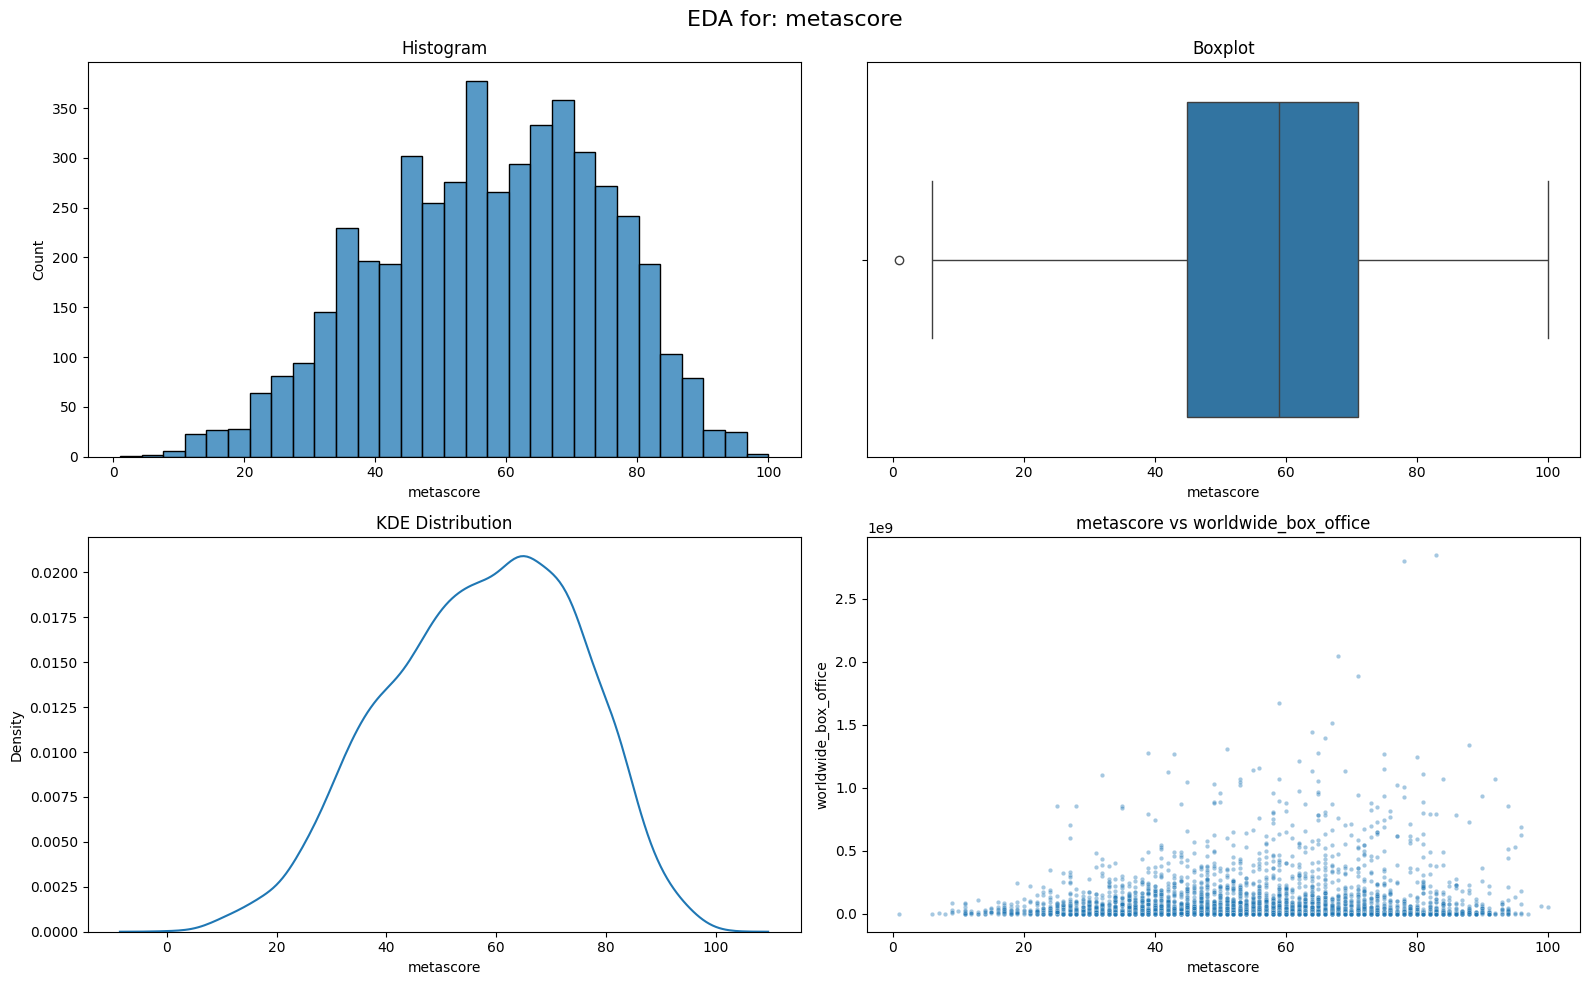

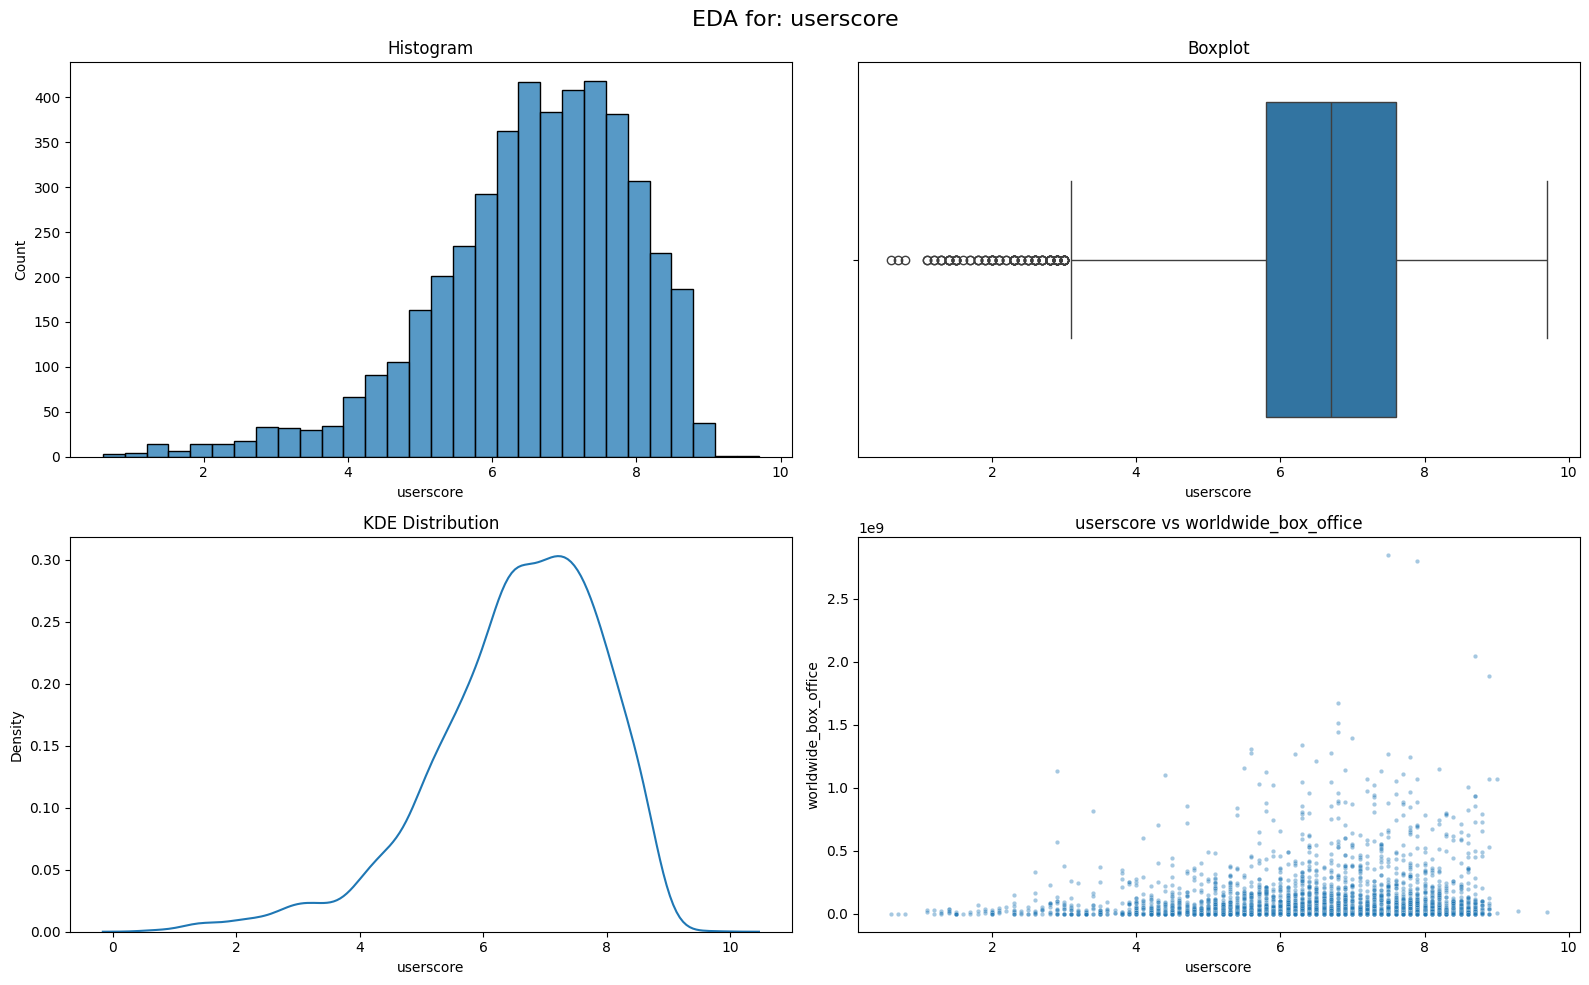

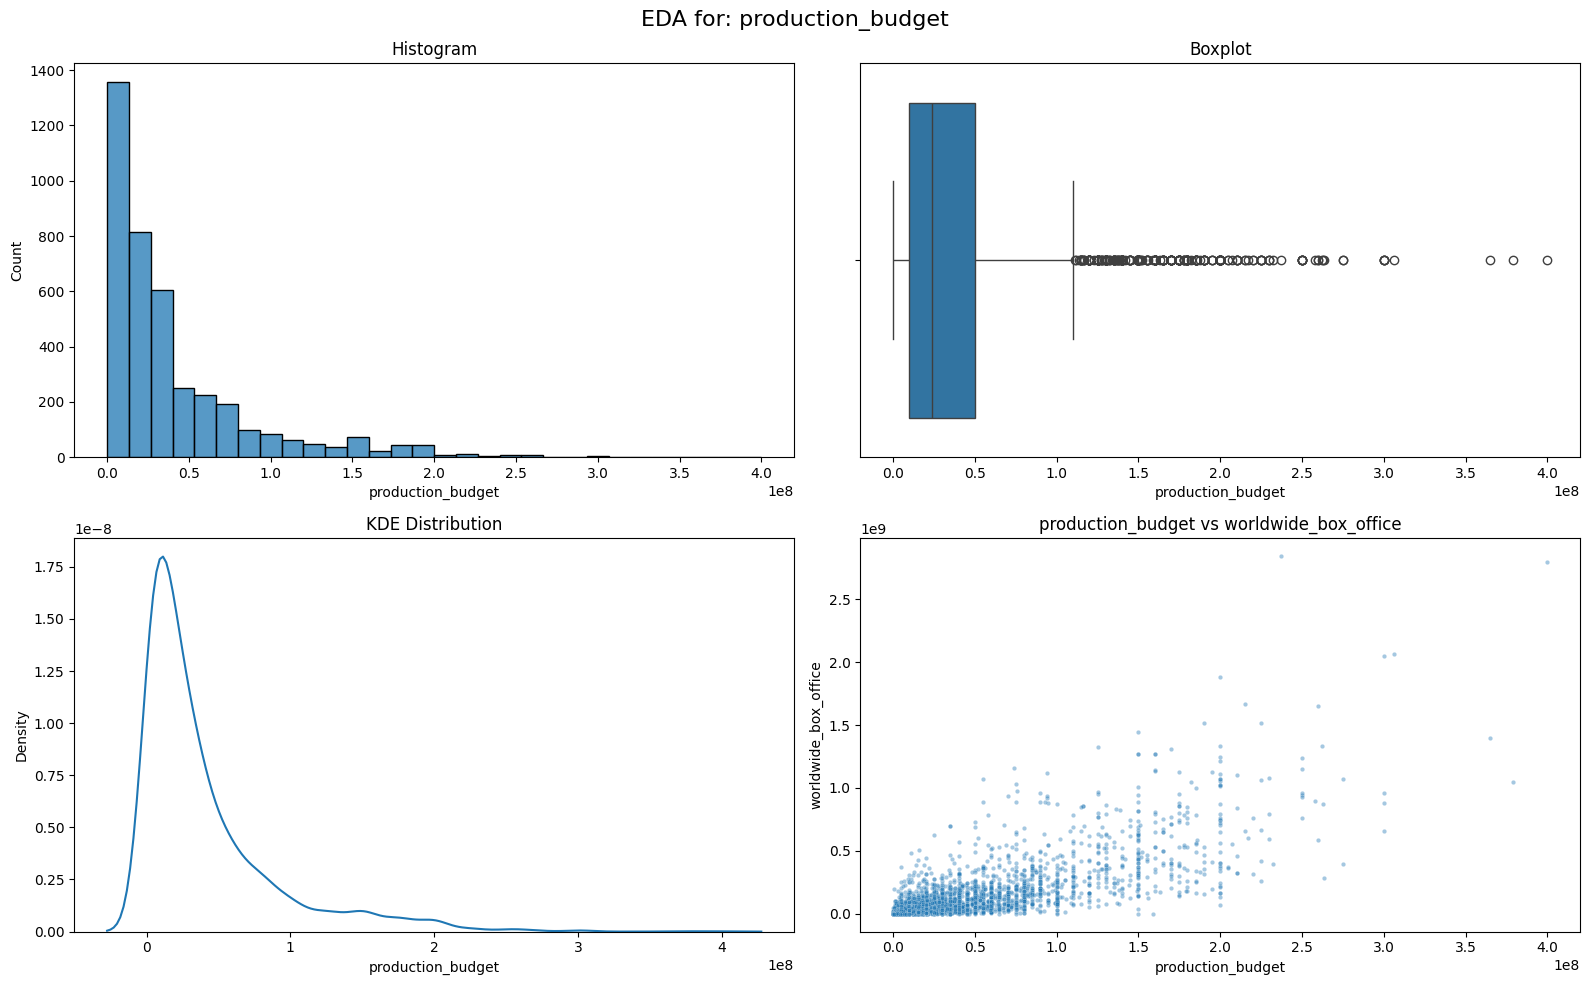

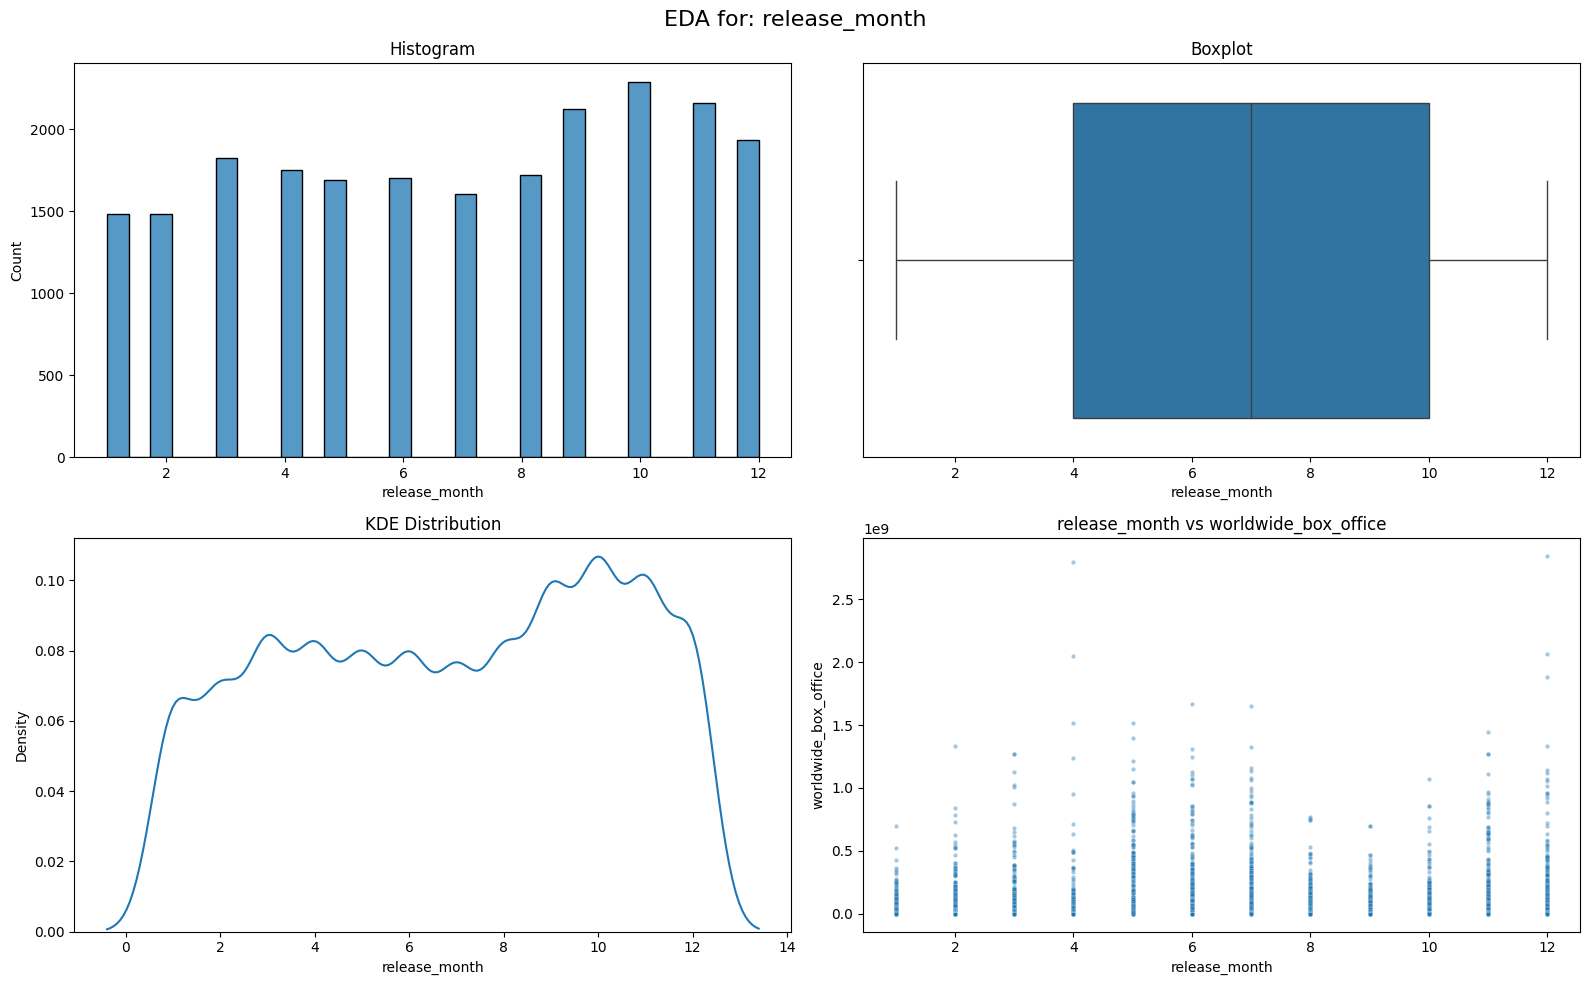

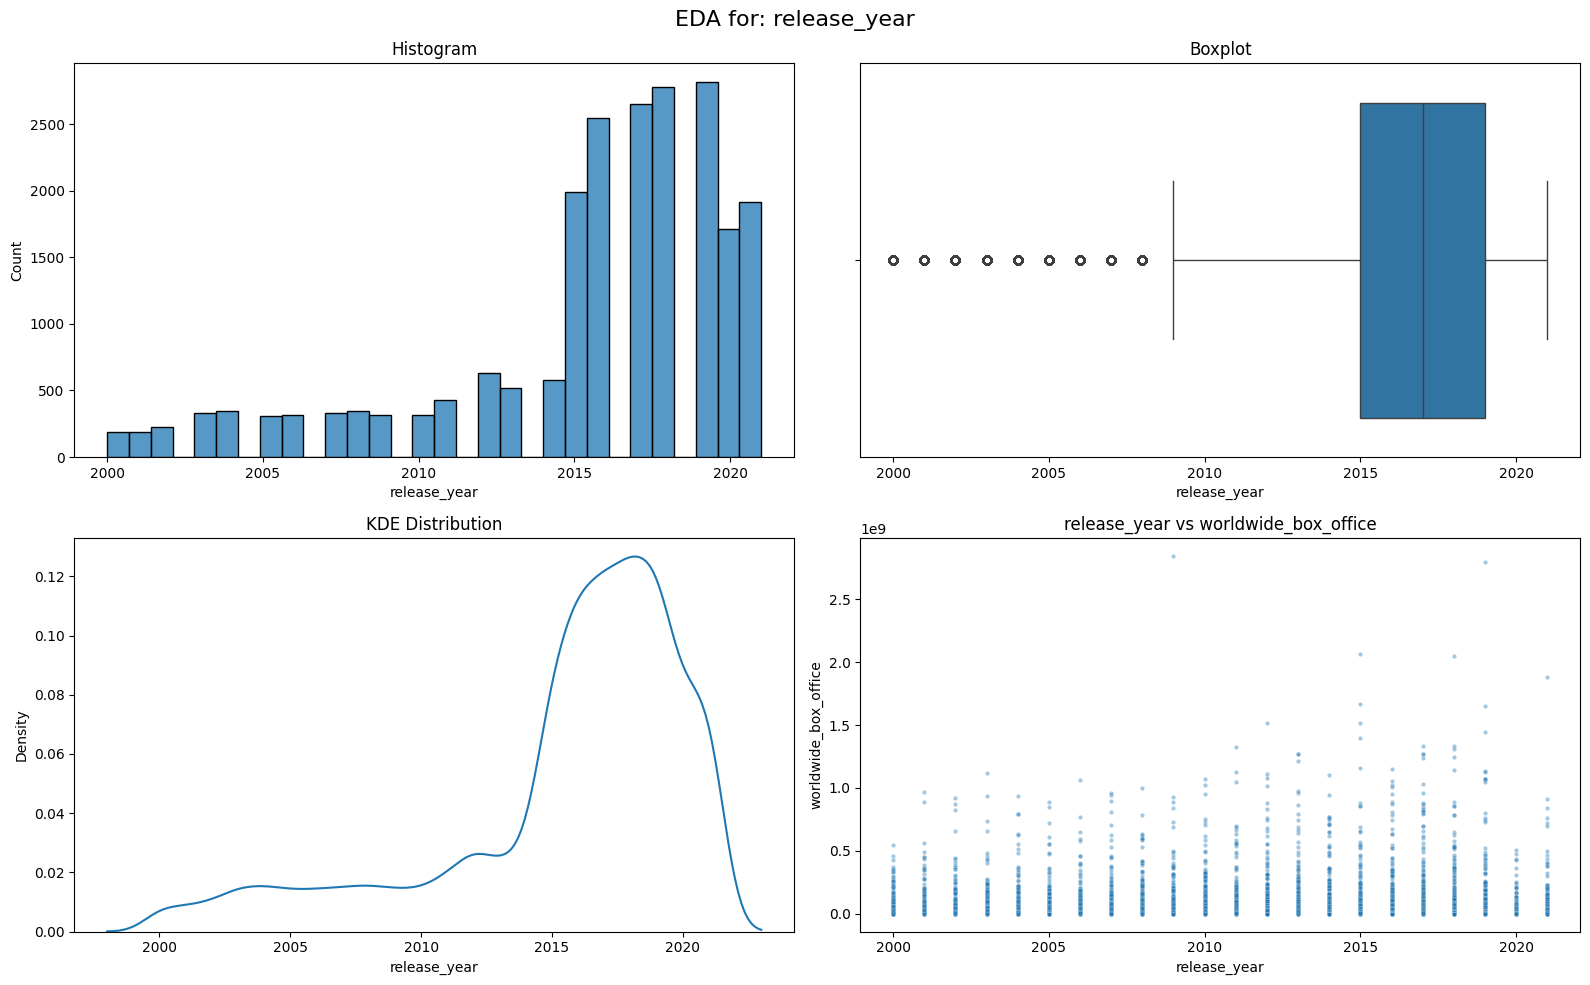

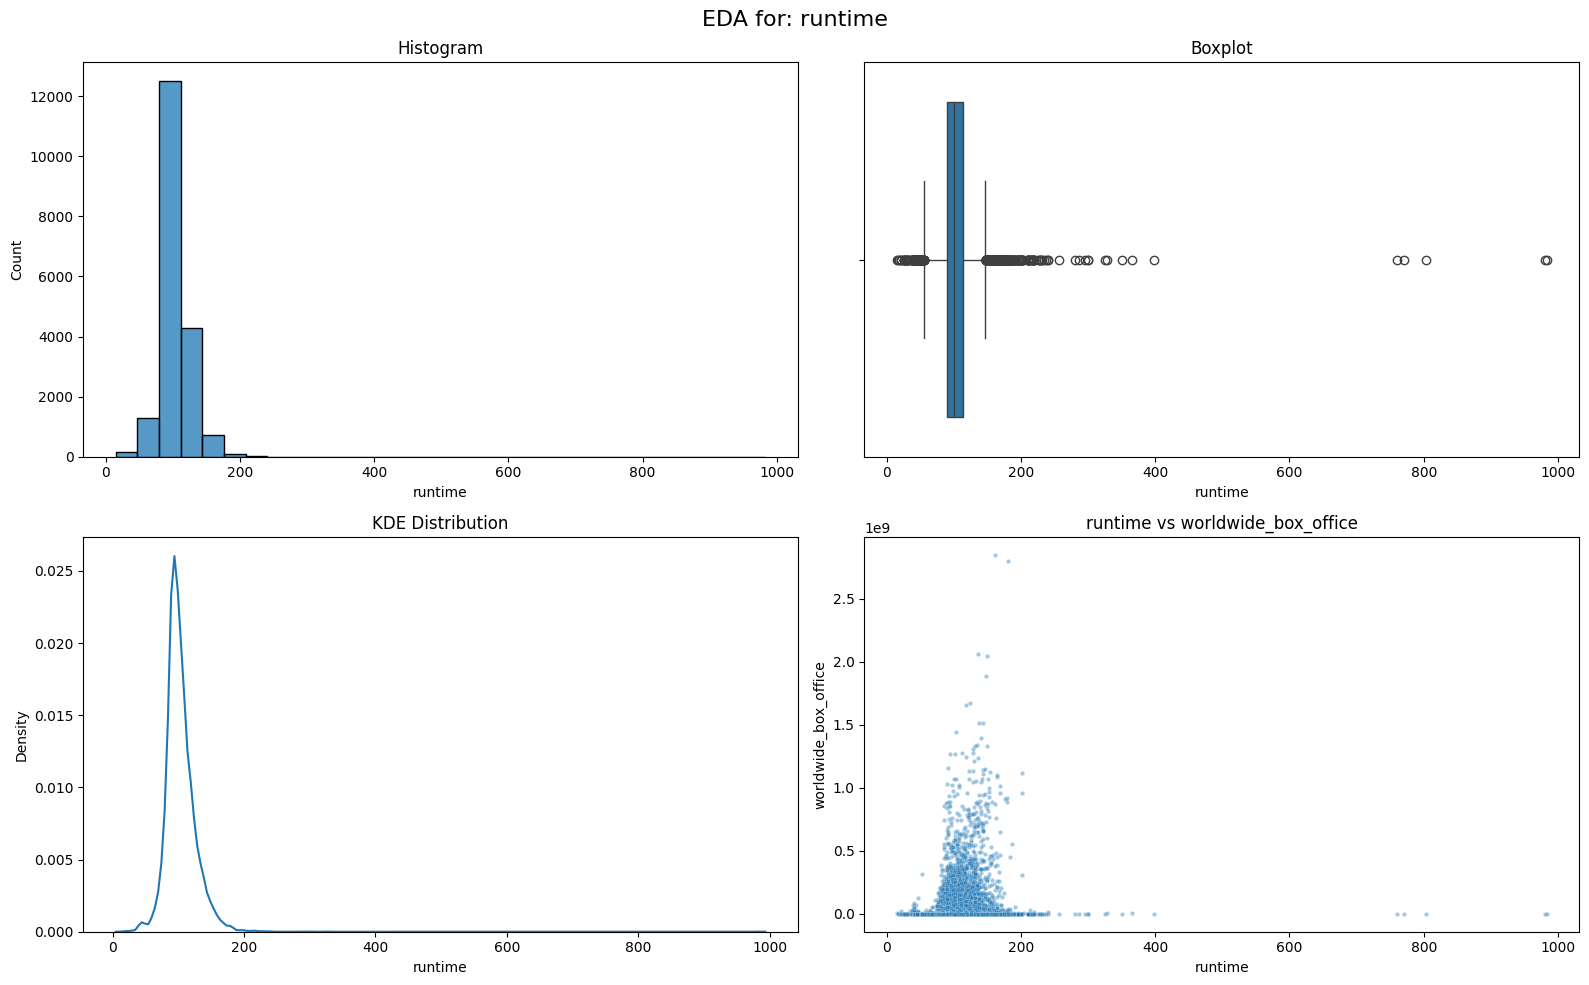

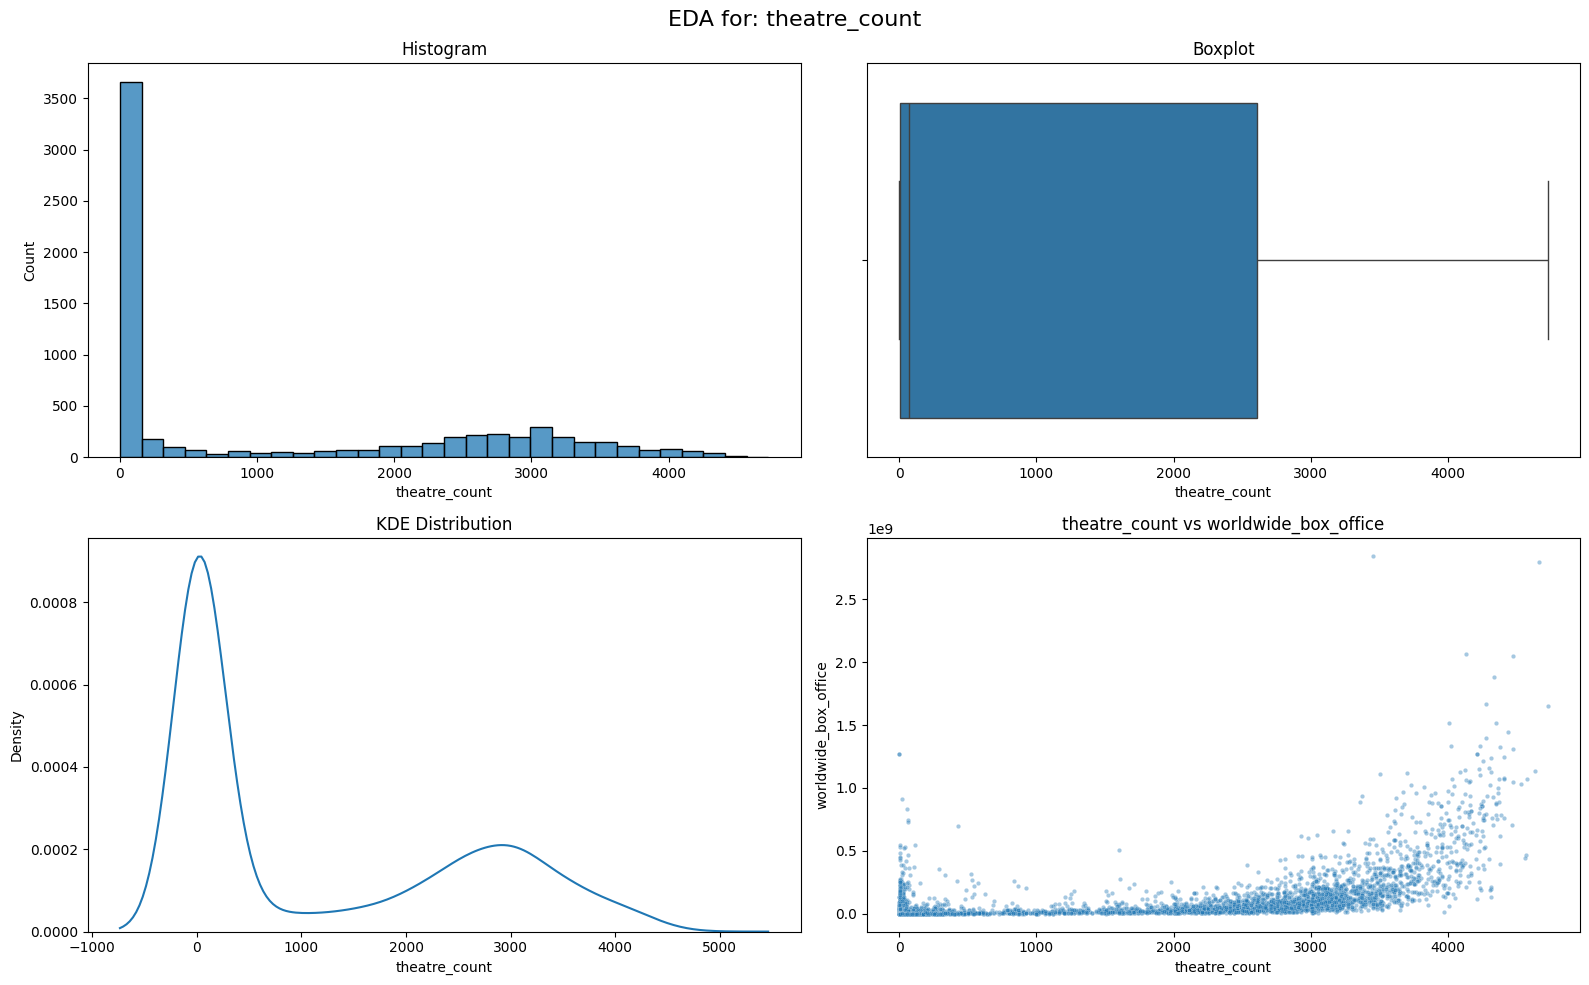

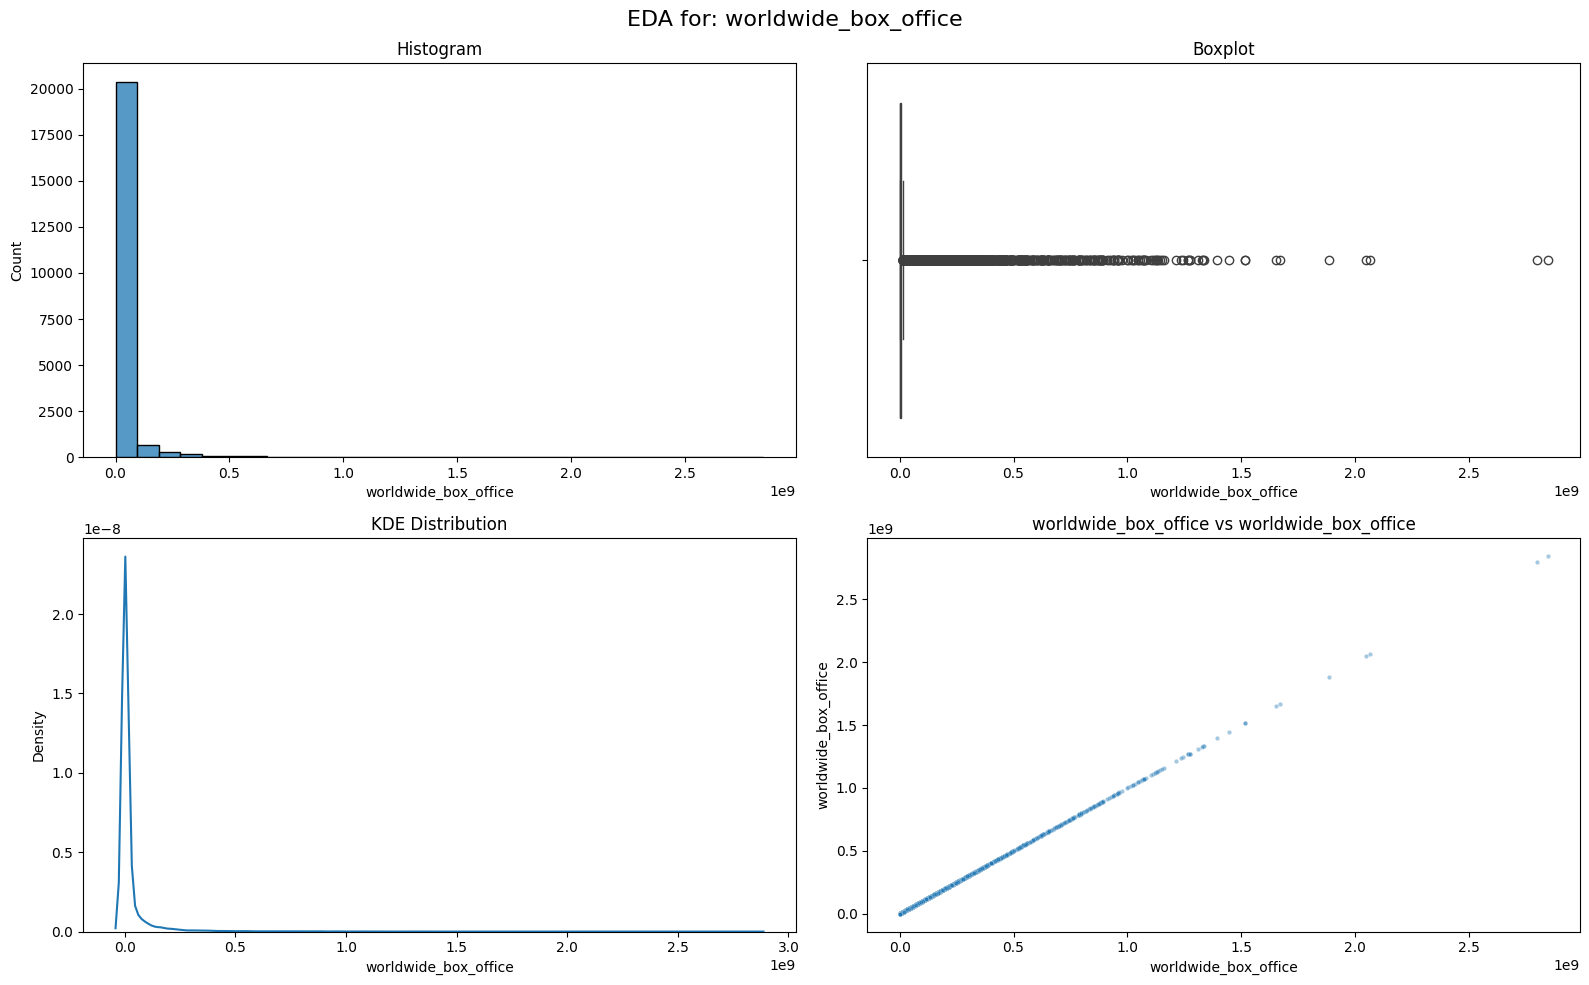

In [68]:
#create a dataframe with a placeholder for all the created column in the customer_final dataframe. 
df_EDA_features= [
    'metascore',
    'userscore',
    'production_budget',
    'release_month',
    'release_year',
    'runtime',
    'theatre_count',
    'worldwide_box_office'       
]

for col in df_EDA_features:
    EDA_plots(movie_data_complete, col, target='worldwide_box_office')


### Reflection on the EDA plots per feature

- **Metascore**: This feature shows an almost normal distribution, centered around 50-70. There is only one outlier and the scatterplot shows no strong linear relationship between the worldwide box office and metascore. This means that the score of the critics alone is NOT a strong predictor of the box office performance

- **Userscore**: This feature shows a right skewed distribution, with most movies receiving an 5 - 8. The boxplot shows some outliers around the 1, these could be people that did not rate the movie honestly. The scatterplot shows that popular movies can have high box office results, but most of them do not. Meaning that userscore alone is also not a strong predictor of box office performance. 

- **Production_budget**: This features showes a heavily left skewed distribution in which most movies have a production budget of less then 50000000. However, the boxplot showes that there are also movies that have budgets as high as 400,000,000. Interestingly, the scatterplot does show a positive linear relationship. Although not every movie with high production budget succeeds, most of them do! 

- **Release_month**: The release month is evenly distributed, with some months showing small dips. The scatterplots show some small peaks in the summer and winter. It is not a very strong predictor by itself, but could be useful after one hot encoding in the future.

- **Release_year**: The released year show very expected behaviour. More movies have been released in more recent years and the movies tend to earn more in recent years. This is probably due to inflation and general market growth.

- **Runtime**: The distribution shows that most movies have a runtime of around 100-150 minutes. There is no clear relationship between runtime and box office performance based on the scatterplot. This is a weak predictor by itself.

- **Theatre_count**: This distribution is extremely skewed. Most movies open in very few theatres, but a few movies open in way more theatres. These will probably be blockbuster movies. The scatterplot however shows a very strong positive relationship between the amount of theatres and the worldwide box office. It is also seen that as soon as a movie is showed in more then 4000 theatres, it almost always means more revenue. This feature might need a log transform to handle the skeweness but it will be a very strong predictor.

- **Worldwide_box_office**: The target shows a heaviliy left skewed distribution. Meaning that most movies make a few million and some movies make billions. 


### 1.4 Inferential statistics
In this chapter, we will move from descriptive statistics to inferential statistics. The numerical features (X1, X2, X3, X6, X7) will be examined with Pearson and Spearmon correlation testing. The categorical features (X4, X5, X8) will be examined with either ANOVA or Kruskal wallis depending on the characterics. 

### Assummptions reflection: 
- Pearson correlation assumptions:
    1. The relationship between the variables is linear
    2. The data is normaly distributed
    3. The data is on a continuous scale
    4. There should be no extreme outliers 

- **X1**: Metascore does not violate any assumptions. Although the scatterplot does not show strong linearity, is does show some. 
- **X2**: Userscore **does** violate assumptions. There are some outliers at the 1, and the distribution is right skewed. Therefore, this is not a good fit for the pearson   correlation test
- **X3**: Altough production budget shows linearity, there are extreme outliers and the data is highly left skewed. Therefore it **does** violate assumptions
- **X4**: Genre is not a numerical feature, does not fit pearson
- **X5**: Release date is not a numerical feature, does not fit pearson 
- **X6**: Runtime shows a weak linearity and a right skewed distribution and **does** violate the assumptions
- **X7**: Theatre count **does** violate the assumption due to the extreme skew.
- **X8**: MPAA Rating is not a numerical feature, does not fit pearson
- **X9**: Movie Summary is not a numerical feature, does not fit pearson
- **X10**: Review Text is not a numerical feature, does not fit pearson

Conclusion: the only feature suited for pearson correlation is metascore. However, the target feature violates the assumptions as well. Since pearson correlation is a bivariate test, Pearson is not suited at all. To find correlation but mitigate these violations, Spearman rank correlation is used.



#### 1.4.1: Correlation analysis


In [ ]:
# 1. Correlation analysis for continuous data
# Based on our assumptions reflection, we use Spearman correlation due to:
# - Non-normal distributions (skewed data)
# - Presence of outliers
# - Non-linear relationships

# Select all continuous features and the target variable
scale_features = [
    'metascore',              # X1
    'userscore',              # X2
    'production_budget',      # X3
    'runtime',                # X6
    'theatre_count',          # X7
    'release_year',           # from X5
    'worldwide_box_office'    # Target
]

# Calculate Spearman correlation (rank-based, robust to outliers and non-linearity)
spearman_corr = movie_data_complete[scale_features].corr(method='spearman')

print("Spearman Correlation Matrix:")
print("=" * 80)
print(spearman_corr.round(3))
print("\n")

# Focus on correlations with target variable
print("Spearman Correlations with Worldwide Box Office:")
print("=" * 80)
target_corr = spearman_corr['worldwide_box_office'].sort_values(ascending=False)
print(target_corr)

# Visualize with heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Spearman correlation heatmap
sns.heatmap(
    spearman_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[0],
    cbar_kws={'label': 'Correlation Coefficient'}
)
axes[0].set_title('Spearman Correlation Matrix\n(Rank-based, robust to outliers)', fontsize=14, pad=20)

# For comparison, also show Pearson (even though assumptions are violated)
pearson_corr = movie_data_complete[scale_features].corr(method='pearson')
sns.heatmap(
    pearson_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[1],
    cbar_kws={'label': 'Correlation Coefficient'}
)
axes[1].set_title('Pearson Correlation Matrix\n(For comparison - assumptions violated)', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# Statistical significance testing for key correlations with target
print("\n" + "=" * 80)
print("Statistical Significance Tests (Spearman) for correlations with target:")
print("=" * 80)

from scipy.stats import spearmanr

for feature in scale_features:
    if feature != 'worldwide_box_office':
        # Remove NaN values for the pair
        valid_data = movie_data_complete[[feature, 'worldwide_box_office']].dropna()
        
        if len(valid_data) > 0:
            corr, p_value = spearmanr(valid_data[feature], valid_data['worldwide_box_office'])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"{feature:25s}: ρ = {corr:6.3f}, p = {p_value:.4e} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# categoricals vs target (genre / rating / release year)

### Interpretation of Spearman Correlation Results

**Why Spearman over Pearson?**

Based on our assumptions reflection, we use **Spearman correlation** because:
1. Our data contains **extreme outliers** (production budget, theatre count, box office)
2. Distributions are **highly skewed** (not normally distributed)
3. Relationships may be **non-linear** or monotonic rather than strictly linear

Spearman correlation is rank-based, making it robust to these violations.

**Key Findings:**

The correlation analysis reveals which features have the strongest monotonic relationships with worldwide box office:

**Strong Predictors (Expected):**
- **theatre_count**: Likely shows the strongest positive correlation - wide releases correlate with higher box office
- **production_budget**: Higher budgets tend to correlate with higher revenues (big-budget films)
- **release_year**: Positive correlation due to inflation and market growth over time

**Moderate Predictors:**
- **metascore** and **userscore**: May show weak to moderate positive correlations
- Quality ratings alone don't guarantee commercial success, but there's likely some relationship

**Weak Predictors:**
- **runtime**: Likely shows little to no correlation with box office performance

**Important Notes:**
1. Correlation ≠ Causation: High correlation doesn't mean one causes the other
2. Statistical significance (p-values) indicates whether correlations are reliable or due to chance
3. Even weak correlations can be useful in combination with other features in ML models
4. The comparison between Spearman and Pearson shows how outliers affect linear correlation

**Next Steps:**
These correlations inform feature engineering and model selection, but multivariate models can capture complex interactions that univariate correlations miss.

In [70]:
(
    movie_data_complete
    .groupby("genre", observed=False)["worldwide_box_office"]
    .agg(["count", "mean", "median"])
    .sort_values("mean", ascending=False)
    .head(10)
)


,count,mean,median
genre,,,
"Adventure,Fantasy,Comedy,Romance,Family,Musical",1,1.046650e+09,1.046650e+09
"Action,Adventure,Comedy,Crime,Animation,Family",1,1.004630e+09,1.004630e+09
"Adventure,Sci-Fi,Comedy,Crime,Animation,Family",1,9.752168e+08,9.752168e+08
"Action,Adventure,Mystery,Fantasy",1,9.526014e+08,9.526014e+08
"Action,Adventure,Mystery,Fantasy,Romance,Family",1,9.294111e+08,9.294111e+08
"Adventure,Mystery,Fantasy,Family",5,8.912934e+08,8.867462e+08
"Action,Adventure,Comedy,Romance,Animation,Family",1,8.866868e+08,8.866868e+08
"Action,Adventure,Sci-Fi,Fantasy,Family",1,8.783464e+08,8.783464e+08
"Action,Adventure,Sci-Fi,Drama,Fantasy,Comedy",1,8.504828e+08,8.504828e+08


### Categorical variables and sales (genres)

We grouped the data by the full `genre` string and computed the **count**, **mean** and **median** of `worldwide_box_office` for each group.

What we see in the top rows:

- The highest average box office comes from **long genre combinations** such as  
  `Adventure,Fantasy,Comedy,Romance,Family,Musical` or  
  `Action,Adventure,Comedy,Crime,Animation,Family`.  
  These are all big, broad, family-oriented combinations (adventure, fantasy, comedy, family, animation).

- For most of these top genre combinations the **count is only 1**.  
  This means the high mean is driven by a **single blockbuster** in that category, so we cannot generalise too much from these rows.

- The only combination in the top 10 with more observations is  
  `Adventure,Mystery,Fantasy,Family` (5 movies) with an average box office of roughly **8.9**.  
  This confirms that large adventure/fantasy family movies are among the strongest commercial performers.

Implications for modelling:

- Genre clearly matters, but using the **full genre string** leads to many very rare combinations (mostly count = 1).  
- Before using genre in our models, it will be better to **simplify it**, for example by extracting a `main_genre` or grouping genres into a smaller number of high-level categories. This reduces sparsity and makes the model easier to interpret.


# outliers and log-transformation

<Axes: xlabel='worldwide_box_office', ylabel='Count'>

Text(0.5, 1.0, 'Worldwide box office (raw)')

<Axes: xlabel='worldwide_box_office', ylabel='Count'>

Text(0.5, 1.0, 'Worldwide box office (log-transformed)')

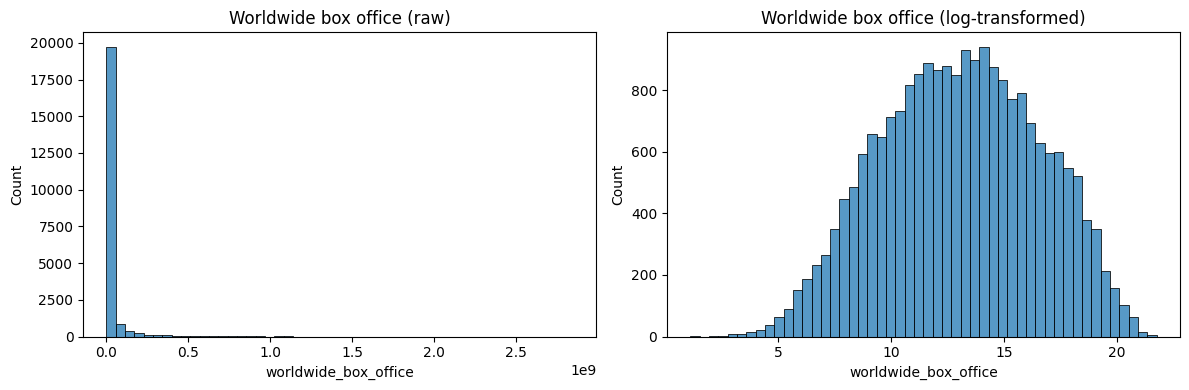

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(movie_data_complete["worldwide_box_office"].dropna(), ax=axes[0], bins=50)
axes[0].set_title("Worldwide box office (raw)")

sns.histplot(
    np.log1p(movie_data_complete["worldwide_box_office"].dropna()),
    ax=axes[1],
    bins=50
)
axes[1].set_title("Worldwide box office (log-transformed)")

plt.tight_layout()
plt.show()


### Outliers and transformations

The two histograms compare the distribution of `worldwide_box_office` **before** and **after** a log transformation.

**Raw scale (left plot)**  
- The distribution is extremely right-skewed.  
- Most movies earn relatively modest amounts, and a small number of blockbusters reach very high box office values.  
- The long tail on the right makes it hard for a model to treat “normal” movies and extreme hits in a balanced way, because the loss will be dominated by a few very large values.

**Log-transformed scale (right plot)**  
- After applying `log(1 + worldwide_box_office)`, the histogram becomes much more spread out and closer to a bell-shaped distribution.  
- The blockbusters are still at the high end, but they are no longer so extreme compared to the bulk of the data.  
- This makes patterns easier to see and typically leads to a more stable regression model.

**Implication for modelling**  
For these reasons, it is reasonable to train our models on  
`log(1 + worldwide_box_office)` instead of the raw box office.  
We can always transform predictions back to the original scale by applying the inverse transformation `exp(pred) - 1`.


# Missing Values

### Missing values: final decisions

Based on the missing value inspection:

- We drop completely empty or irrelevant columns (e.g. `Unnamed: 8`).
- **For our modelling dataset we keep only movies with a non-missing `worldwide_box_office` and `production_budget`, because both are essential for our research question.**
- For other features with moderate missingness (e.g. `runtime`), we either:
  - drop the rows (for smaller amounts of missingness), or
  - apply simple imputation (e.g. median or most frequent value) in a later preprocessing step.

These choices are based on the trade-off between data quality and keeping enough observations for training.
